# **7. Validacion Avanzada, Tuning e Interpretabilidad a los modelos estudiados**

# **7.0 Previo**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN


from sklearn.linear_model import (
    LogisticRegression, SGDClassifier, RidgeClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc,
    classification_report, roc_auc_score, make_scorer
)
from sklearn.inspection import permutation_importance

from skopt import BayesSearchCV
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [5]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [6]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [11]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


# **7.1 Validacion Avanzada, Tuning e Interpretabilidad a KNN**

In [ ]:
knn_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  
    ("smote", SMOTE(random_state=42)),
    ("classifier", KNeighborsClassifier(algorithm="kd_tree"))
])


In [ ]:
param_grid = {
    "classifier__n_neighbors": [3, 5, 7, 9],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2]  # p=1: Manhattan, p=2: Euclidean
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc", 
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='kd_tree'))]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [3, 5, 7, 9],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)
y_pred_proba = best_knn.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))


Mejores hiperparámetros: {'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'distance'}
Mejor AUC (CV): 0.6234155244056163
Accuracy: 0.5869607939471357
Precision: 0.5535282479665861
Recall: 0.5368297622854706
F1: 0.5450511391309053
AUC: 0.6184857681848829



Matriz de Confusión:
[[6911 4062]
 [4345 5036]]


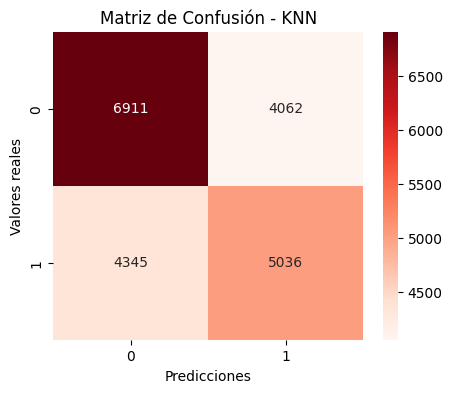

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - KNN")
plt.show()

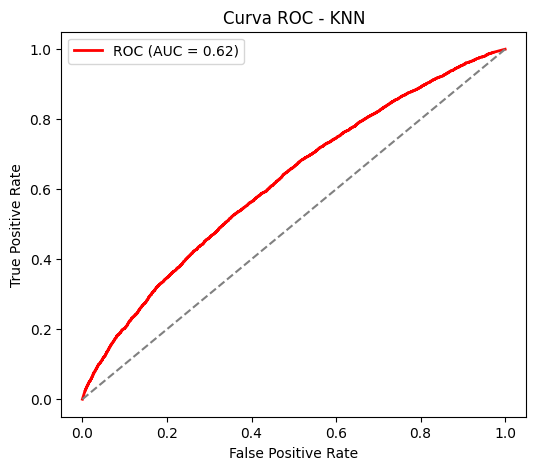

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_val = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - KNN")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_knn, "best_knn_pipeline.pkl")
print("Modelo KNN guardado en best_knn_pipeline.pkl")


Modelo KNN guardado en best_knn_pipeline.pkl


# **7.2 Validacion Avanzada, Tuning e Interpretabilidad a Clasificador Bayesiano**

In [ ]:
bayes_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # tu ColumnTransformer o preprocesamiento
    ("classifier", GaussianNB())
])

In [ ]:
param_grid = {
    "classifier__var_smoothing": np.logspace(-9, -6, 5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
grid_search = GridSearchCV(
    estimator=bayes_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-4,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                                       ('classifier', GaussianNB())]),
             n_jobs=-4,
             param_grid={'classifier__var_smoothing': array([1.00000000e-09, 5.62341325e-09, 3.16227766e-08, 1.77827941e-07,
       1.00000000e-06])},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

best_bayes = grid_search.best_estimator_

y_pred = best_bayes.predict(X_test)
y_pred_proba = best_bayes.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))


Mejores hiperparámetros: {'classifier__var_smoothing': np.float64(1e-06)}
Mejor AUC (CV): 0.6425919702346155
Accuracy: 0.5018669548983001
Precision: 0.4798361353479464
Recall: 0.9614113633940945
F1: 0.6401675125102033
AUC: 0.6422601355054391


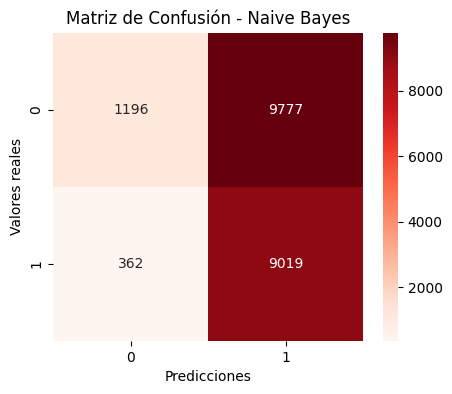

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()

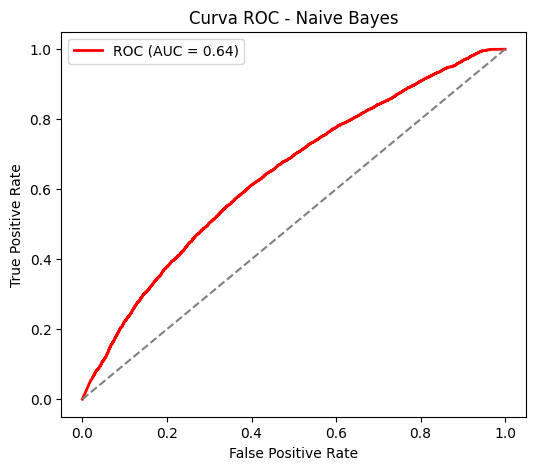

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_val = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Naive Bayes")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_bayes, "best_bayes_pipeline.pkl")
print("Modelo ClasificadorBayes guardado en best_bayes_pipeline.pkl")


Modelo ClasificadorBayes guardado en best_bayes_pipeline.pkl


# **7.3 Validacion Avanzada, Tuning e Interpretabilidad a Regresion Logistica**

In [ ]:
ridge_saga_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  # tu ColumnTransformer
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=1000,
        random_state=42,
        n_jobs=4
    ))
])

In [ ]:
param_grid = {
    "classifier__C": np.logspace(-3, 3, 7)  # valores desde 0.001 a 1000
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=ridge_saga_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=4,
    verbose=1
)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=4,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=4,
             param_grid={'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc', verbose=1)

In [ ]:
best_ridge_saga = grid_search.best_estimator_

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

# Predicciones en test
y_pred = best_ridge_saga.predict(X_test)
y_pred_proba = best_ridge_saga.predict_proba(X_test)[:, 1]

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: {'classifier__C': np.float64(1000.0)}
Mejor AUC (CV): 0.6795034428648699
Accuracy: 0.6262651075955586
Precision: 0.5961413396921743
Recall: 0.5862914401449739
F1: 0.591175364110281
AUC: 0.6800578326429304


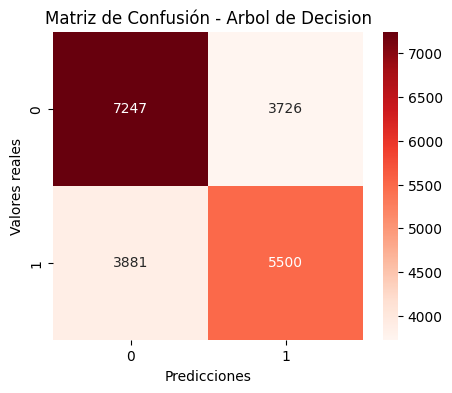

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - Arbol de Decision")
plt.show()

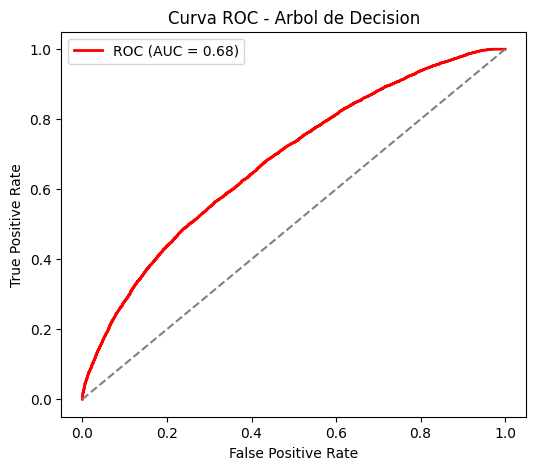

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_val = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Arbol de Decision")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_ridge_saga, "best_ridge_saga_model.pkl")
print("Modelo LogRes  guardado en best_ridge_saga_model.pkl")


Modelo LogRes  guardado en best_ridge_saga_model.pkl


# **7.4 Validacion Avanzada, Tuning e Interpretabilidad a Arboles de Decision**

In [ ]:
dt_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # tu ColumnTransformer
    ("classifier", DecisionTreeClassifier(random_state=42))
])

In [ ]:
# --- Hiperparámetros a tunear ---
param_grid = {
    "classifier__max_depth": [3, 5, 7, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__criterion": ["gini", "entropy"]
}

In [ ]:
# --- Validación cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

In [ ]:

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [3, 5, 7, 10, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='roc_auc', verbose=2)

In [ ]:
best_dt = grid_search.best_estimator_

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Mejor AUC (CV): 0.6706414191453354

Métricas en test:
Accuracy: 0.6322590154269431
Precision: 0.6310840707964602
Recall: 0.4865152968766656
F1: 0.5494492265093601
AUC: 0.6735269171950614


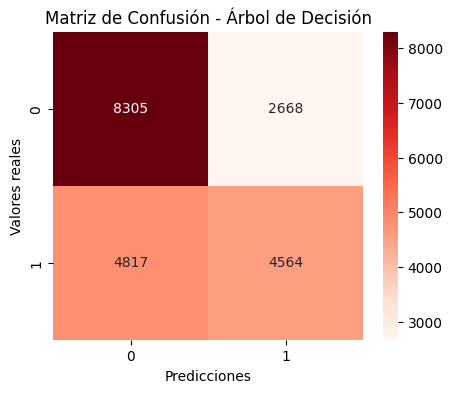

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.show()



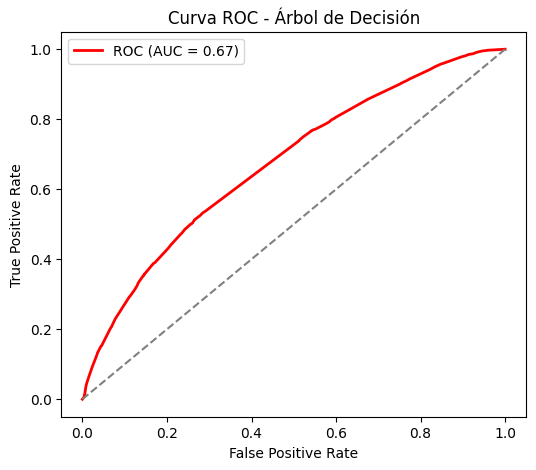

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_dt, "best_tree_pipeline.pkl")
print("Modelo Arbol de decision guardado en best_tree_pipeline.pkl")


Modelo Arbol de decision guardado en best_tree_pipeline.pkl


# **7.5 Validacion Avanzada, Tuning e Interpretabilidad a Random Forest**

In [ ]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # tu ColumnTransformer
    ("classifier", RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [5, 10, 15, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_features": ["sqrt", "log2"]
}

In [ ]:
# --- Validación cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=8,
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=8,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 15, None],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [ ]:
best_rf = grid_search.best_estimator_

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Mejor AUC (CV): 0.6947631998275645

Métricas en test:
Accuracy: 0.6419868330549278
Precision: 0.6420624151967436
Recall: 0.504423835412003
F1: 0.5649811951525282
AUC: 0.6958367435266412


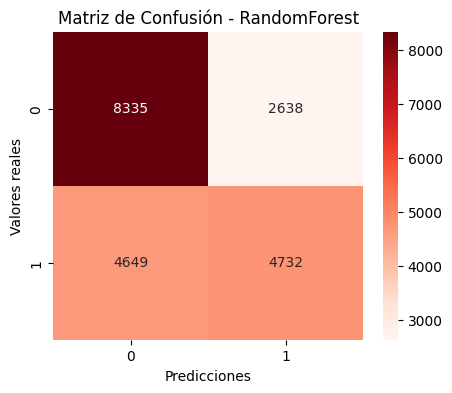

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - RandomForest")
plt.show()



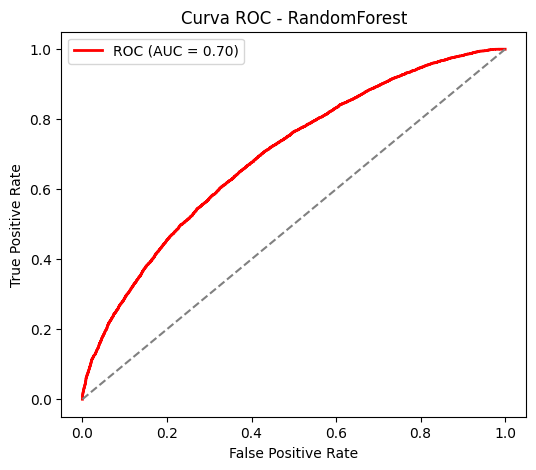

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - RandomForest")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_rf, "best_rf_pipeline.pkl")
print("Modelo RandomForest guardado en best_rf_pipeline.pkl")


Modelo RandomForest guardado en best_rf_pipeline.pkl


# **7.6 Validacion Avanzada, Tuning e Interpretabilidad a XGBoost**

In [ ]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()


xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_estimators=500,
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
param_space = {
    'classifier__max_depth': (3, 10),
    'classifier__learning_rate': (0.01, 0.3, 'log-uniform'),
    'classifier__subsample': (0.5, 1.0, 'uniform'),
    'classifier__colsample_bytree': (0.5, 1.0, 'uniform'),
    'classifier__min_child_weight': (1, 10),
    'classifier__gamma': (0.0, 5.0, 'uniform'),
    'classifier__reg_lambda': (0.0, 10.0, 'uniform'),
    'classifier__reg_alpha': (0.0, 10.0, 'uniform')
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_search = BayesSearchCV(
    estimator=xgb_pipe,
    search_spaces=param_space,
    n_iter=55,                # puedes aumentar a 50+ si tienes más tiempo
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [ ]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                         (...
              search_spaces={'classifier__colsample_bytree': (0.5, 1.0,
                                                              'uniform'),
                             'classifier__gamma': (0.0, 5.0, 'uniform'),
                             'classifier__learning_rate': (0.01, 0.3,
                                                           'log-uniform'),
                             'classifier__max_depth': (3, 10),
                             'classifier__min_child_weight': (1, 10),
                             'classifier__reg_alpha': (0.0, 10.0, 'uniform'),
                             'classifier__reg_lambda': (0.0, 10.0, 'uniform'),
                             'classifier__subsample': (0.5, 1.0, 'uniform')},
              verbose=2)

In [ ]:
best_xgb = bayes_search.best_estimator_

print("Mejores hiperparámetros:", bayes_search.best_params_)
print("Mejor AUC (CV):", bayes_search.best_score_)

y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: OrderedDict([('classifier__colsample_bytree', 0.6178270308869578), ('classifier__gamma', 1.6918026180213865), ('classifier__learning_rate', 0.11081724798111653), ('classifier__max_depth', 6), ('classifier__min_child_weight', 10), ('classifier__reg_alpha', 3.7832939106502805), ('classifier__reg_lambda', 9.782922316459892), ('classifier__subsample', 0.8227065806018466)])
Mejor AUC (CV): 0.6970748796984528

Métricas en test:
Accuracy: 0.6454750908912253
Precision: 0.6123041809316319
Recall: 0.6291440144973883
F1: 0.6206098843322818
AUC: 0.6996236500805103


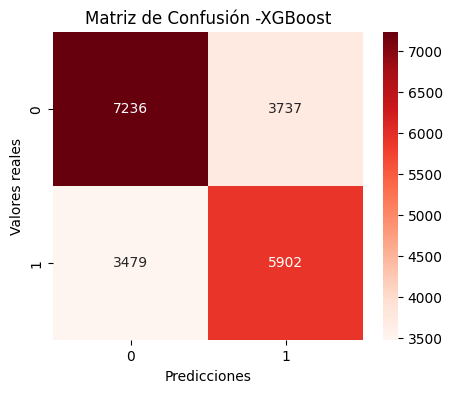

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión -XGBoost")
plt.show()



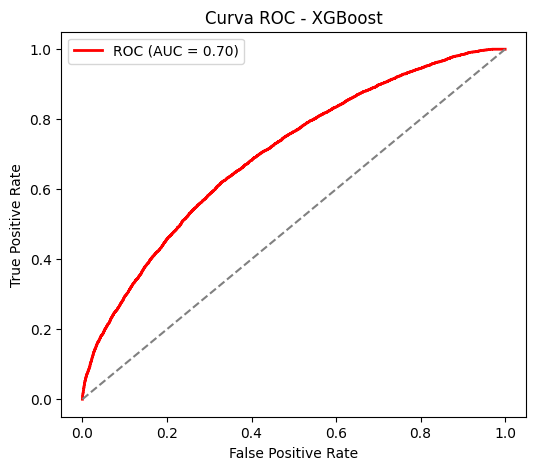

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_xgb, "best_xgb_pipeline.pkl")
print("Modelo XGBoost guardado en best_xgb_pipeline.pkl")

Modelo XGBoost guardado en best_xgb_pipeline.pkl


# **7.7 Validacion Avanzada, Tuning e Interpretabilidad a SVM**

In [ ]:
sgd_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  # tu transformador definido antes
    ("smote", SMOTE(random_state=42)),
    ("classifier", SGDClassifier(
        loss="hinge",          # equivalente a SVM lineal
        penalty="l2",          # regularización L2
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
param_distributions = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": [1e-4, 1e-3, 1e-2, 1e-1],
    "classifier__penalty": ["l2", "l1", "elasticnet"],
    "classifier__max_iter": [1000, 2000, 3000],
    "classifier__tol": [1e-3, 1e-4, 1e-5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
bayes_search = BayesSearchCV(
    estimator=sgd_pipe,
    search_spaces=param_distributions,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=12,
    random_state=42,
    verbose=2
)


In [ ]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                         (...
                                         SGDClassifier(n_jobs=-1,
                                                       random_state=42))]),
              n_iter=30, n_jobs=12, random_state=42, scoring='roc_auc',
              search_spaces={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                             'classifier__loss': ['hinge', 'log_loss',
                                                  'modified_huber'],
                             'classifier__max_iter': [1000, 2000, 3000],
                             'classifier__penalty': ['l2', 'l1', 'elasticnet'],
                             'classifier__tol': [0.001, 0.0001, 1e-05]},
              verbose=2)

In [ ]:
best_svm = bayes_search.best_estimator_

print("Mejores hiperparámetros:", bayes_search.best_params_)
print("Mejor AUC (CV):", bayes_search.best_score_)

y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)[:,1]

print("\nMétricas en test:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: OrderedDict([('classifier__alpha', 0.001), ('classifier__loss', 'log_loss'), ('classifier__max_iter', 3000), ('classifier__penalty', 'l2'), ('classifier__tol', 1e-05)])
Mejor AUC (CV): 0.6786214896038898

Métricas en test:
Accuracy: 0.6233172840719269
Precision: 0.5900588482555695
Recall: 0.5985502611661869
F1: 0.5942742234217071
AUC: 0.6783535398731853


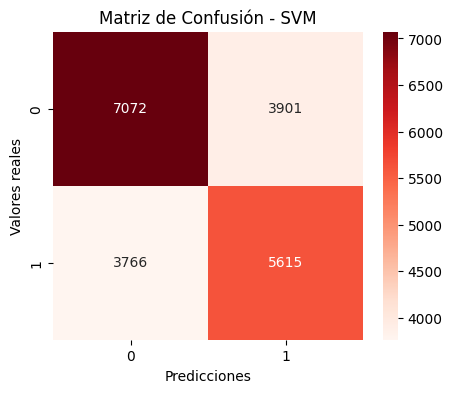

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - SVM")
plt.show()



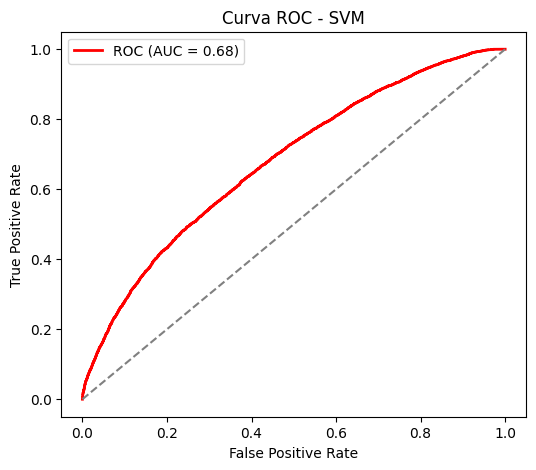

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.show()

In [ ]:
joblib.dump(best_svm, "best_svm_pipeline.pkl")
print("Modelo SVM guardado en best_svm_pipeline.pkl")

Modelo XGBoost guardado en best_xgb_pipeline.pkl


# **7.8 Comparacion Final**

In [3]:
modelos = {
    "Random Forest": joblib.load("best_rf_pipeline.pkl"),
    "XGBoost": joblib.load("best_xgb_pipeline.pkl"),
    "SVM-SGD": joblib.load("best_svm_pipeline.pkl"),
    "LogReg L2 (SAGA)": joblib.load("best_ridge_saga_model.pkl"),
    "KNN-KDTree": joblib.load("best_knn_pipeline.pkl"),
    "Decision Tree": joblib.load("best_tree_pipeline.pkl"),
    "Naive Bayes": joblib.load("best_bayes_pipeline.pkl")
}

In [12]:
resultados = []

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    })

df_resultados = pd.DataFrame(resultados).round(4).sort_values(by="Recall", ascending=False)

In [13]:
display(df_resultados)

Modelo  Accuracy  Precision  Recall      F1     AUC
6       Naive Bayes    0.5019     0.4798  0.9614  0.6402  0.6423
1           XGBoost    0.6455     0.6123  0.6291  0.6206  0.6996
2           SVM-SGD    0.6233     0.5901  0.5986  0.5943  0.6784
3  LogReg L2 (SAGA)    0.6263     0.5961  0.5863  0.5912  0.6801
4        KNN-KDTree    0.5870     0.5535  0.5368  0.5451  0.6185
0     Random Forest    0.6420     0.6421  0.5044  0.5650  0.6958
5     Decision Tree    0.6323     0.6311  0.4865  0.5494  0.6735

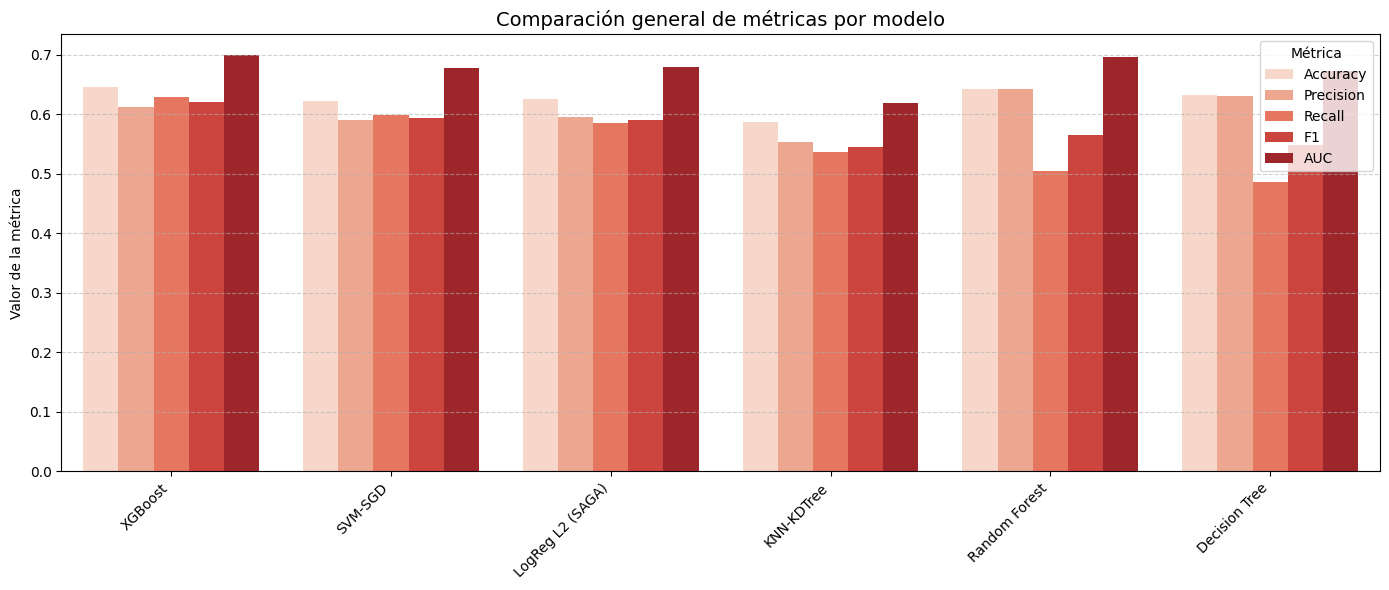

In [15]:
df_resultados_filtrado = df_resultados.iloc[1:]

metricas = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

plt.figure(figsize=(14,6))
sns.barplot(
    data=df_resultados_filtrado.melt(id_vars="Modelo", value_vars=metricas),
    x="Modelo", y="value", hue="variable", palette="Reds"
)
plt.title("Comparación general de métricas por modelo", fontsize=14)
plt.ylabel("Valor de la métrica")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()


# **7.9 Interpretabilidad a Top 3 modelos**

## **7.9.1 XGBoost - scale_pos_weight + Reg(L1/L2) + GaussianSearchCV, CV=5**

In [63]:
xgb_best = joblib.load("best_xgb_pipeline.pkl")

In [64]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# X_train y y_train deben ser los mismos usados para entrenar
X_train_trans = xgb_best.named_steps["preprocessor"].transform(X_train)
X_test_trans = xgb_best.named_steps["preprocessor"].transform(X_test)

# Crear el explicador LIME
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_trans),
    feature_names=xgb_best.named_steps["preprocessor"].get_feature_names_out(),
    class_names=["No", "Sí"],      # Ajusta según tu variable dependiente
    mode="classification"
)


In [65]:
i = 10  # índice de la muestra que quieras analizar
exp = explainer.explain_instance(
    data_row=X_test_trans[i],
    predict_fn=xgb_best.named_steps["classifier"].predict_proba,
    num_features=10  # cuántas características mostrar
)

exp.show_in_notebook(show_table=True)



In [66]:
# Obtener las probabilidades predichas por el modelo
pred_proba = xgb_best.named_steps["classifier"].predict_proba([X_test_trans[i]])[0]
pred_class = np.argmax(pred_proba)

# Explicación local con LIME
lime_features = exp.as_list()
df_lime = pd.DataFrame(lime_features, columns=["Característica", "Peso"])

df_lime["abs_peso"] = df_lime["Peso"].abs()
df_lime = df_lime.sort_values(by="abs_peso", ascending=False).reset_index(drop=True)

print("=" * 70)
print(f"Interpretación LIME para la muestra #{i}")
print("-" * 70)
print(f"Clase predicha: {'Sí' if pred_class == 1 else 'No'}")
print(f"Probabilidades -> No: {pred_proba[0]:.3f} | Sí: {pred_proba[1]:.3f}")
print("\nTop 10 características más influyentes:")
print(df_lime[["Característica", "Peso"]].to_string(index=False))
print("=" * 70)


Interpretación LIME para la muestra #10
----------------------------------------------------------------------
Clase predicha: Sí
Probabilidades -> No: 0.260 | Sí: 0.740

Top 10 características más influyentes:
                                       Característica      Peso
        cat__discharge_disposition_id_Expired <= 0.00  0.582820
cat__discharge_disposition_id_Hospice/Expired <= 0.00  0.388562
                     num__num_lab_procedures <= -0.61 -0.117869
                      cat__chlorpropamide_Yes <= 0.00 -0.093777
                       num__number_emergency <= -0.21 -0.080671
 cat__medical_specialty_Gynecology/Obstetrics <= 0.00  0.075792
                  cat__gender_Unknown/Invalid <= 0.00 -0.074456
            cat__admission_source_id_Transfer <= 0.00  0.069086
         cat__admission_type_id_Trauma Center <= 0.00 -0.055376
                         cat__tolbutamide_Yes <= 0.00 -0.040147


C:\Users\taran\AppData\Local\Temp\ipykernel_16700\1163203388.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


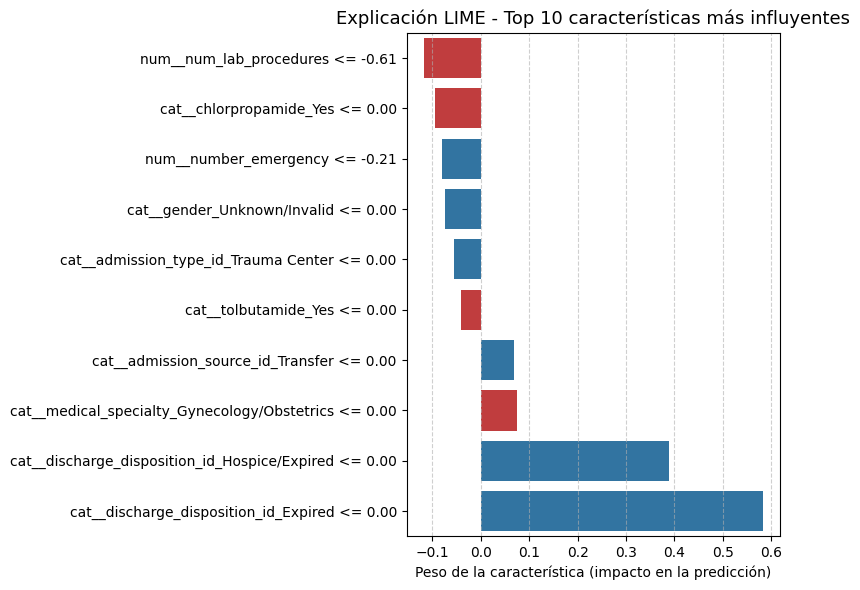

In [67]:
plt.figure(figsize=(8, 6))
colors = ["#d62728" if w > 0 else "#1f77b4" for w in df_lime["Peso"]]

sns.barplot(
    data=df_lime.sort_values(by="Peso", ascending=True),
    x="Peso",
    y="Característica",
    palette=colors
)

plt.title("Explicación LIME - Top 10 características más influyentes", fontsize=13)
plt.xlabel("Peso de la característica (impacto en la predicción)")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [68]:
xgb_model = xgb_best.named_steps["classifier"]
feature_names = xgb_best.named_steps["preprocessor"].get_feature_names_out()
importances = xgb_model.feature_importances_

feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

In [69]:
top10 = feat_importance.head(25)
print(" Top 25 características más importantes en XGBoost:")
display(top10)


 Top 25 características más importantes en XGBoost:


Feature  Importance
0           cat__discharge_disposition_id_Expired    0.147711
1                           num__number_inpatient    0.126608
2                           num__number_emergency    0.069884
3   cat__discharge_disposition_id_Hospice/Expired    0.042528
4                          num__number_outpatient    0.026683
5          cat__admission_source_id_EmergencyRoom    0.025269
6               cat__admission_source_id_Transfer    0.025163
7                           num__number_diagnoses    0.023567
8    cat__medical_specialty_Gynecology/Obstetrics    0.023353
9                         cat__max_glu_serum_none    0.015064
10          cat__discharge_disposition_id_LeftAMA    0.014221
11             cat__discharge_disposition_id_Home    0.013948
12                               cat__age_[70-80)    0.013668
13                             cat__glipizide_Yes    0.012876
14                cat__admission_type_id_Elective    0.012867
15                        cat__max_glu_serum_Norm    0.011584
16                               cat__age_[30-40)    0.011001
17                           num__num_medications    0.009681
18                               cat__age_[80-90)    0.009617
19                            num__num_procedures    0.009368
20                              cat__age_[90-100)    0.009366
21     cat__discharge_disposition_id_ExtendedCare    0.009278
22                                cat__change_Yes    0.008954
23                               cat__age_[50-60)    0.008737
24                            cat__A1Cresult_Norm    0.008379

C:\Users\taran\AppData\Local\Temp\ipykernel_16700\216282851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Importance", y="Feature", palette="Reds_r")


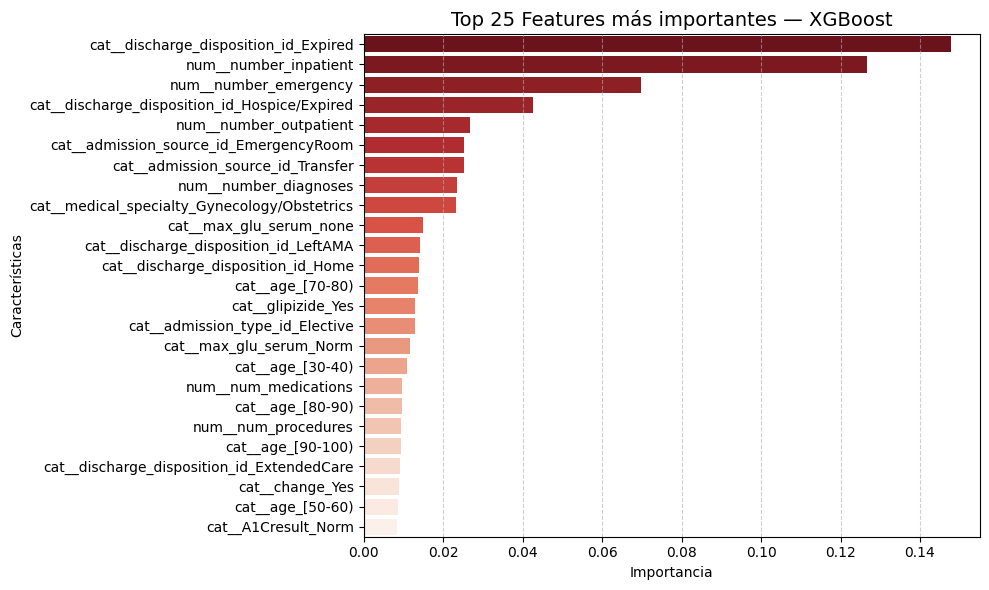

In [70]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10, x="Importance", y="Feature", palette="Reds_r")
plt.title("Top 25 Features más importantes — XGBoost", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## **7.9.2 SVM - SGDClassifier + SMOTE + GridSearchCV, CV=5**

In [71]:
svm_best = joblib.load("best_svm_pipeline.pkl")

In [72]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

X_train_trans = svm_best.named_steps["preprocessor"].transform(X_train)
X_test_trans = svm_best.named_steps["preprocessor"].transform(X_test)

explainer = LimeTabularExplainer(
    training_data=np.array(X_train_trans),
    feature_names=svm_best.named_steps["preprocessor"].get_feature_names_out(),
    class_names=["No", "Sí"],      # Ajusta según tu variable dependiente
    mode="classification"
)


In [73]:
i = 10  # índice de la muestra que quieras analizar
exp = explainer.explain_instance(
    data_row=X_test_trans[i],
    predict_fn=svm_best.named_steps["classifier"].predict_proba,
    num_features=10  # cuántas características mostrar
)

exp.show_in_notebook(show_table=True)

In [74]:
pred_proba = svm_best.named_steps["classifier"].predict_proba([X_test_trans[i]])[0]
pred_class = np.argmax(pred_proba)

lime_features = exp.as_list()
df_lime = pd.DataFrame(lime_features, columns=["Característica", "Peso"])

df_lime["abs_peso"] = df_lime["Peso"].abs()
df_lime = df_lime.sort_values(by="abs_peso", ascending=False).reset_index(drop=True)

print("=" * 70)
print(f"Interpretación LIME para la muestra #{i}")
print("-" * 70)
print(f"Clase predicha: {'Sí' if pred_class == 1 else 'No'}")
print(f"Probabilidades -> No: {pred_proba[0]:.3f} | Sí: {pred_proba[1]:.3f}")
print("\nTop 10 características más influyentes:")
print(df_lime[["Característica", "Peso"]].to_string(index=False))
print("=" * 70)


Interpretación LIME para la muestra #10
----------------------------------------------------------------------
Clase predicha: Sí
Probabilidades -> No: 0.351 | Sí: 0.649

Top 10 características más influyentes:
                                       Característica      Peso
        cat__discharge_disposition_id_Expired <= 0.00  0.321352
    cat__discharge_disposition_id_Transferred <= 0.00 -0.161915
    cat__discharge_disposition_id_ExtendedCare > 0.00  0.147522
cat__discharge_disposition_id_Hospice/Expired <= 0.00  0.128024
                       num__number_emergency <= -0.21 -0.111187
                              cat__age_[0-10) <= 0.00  0.105175
            cat__admission_source_id_Transfer <= 0.00  0.098080
        cat__discharge_disposition_id_LeftAMA <= 0.00 -0.076534
 cat__medical_specialty_Gynecology/Obstetrics <= 0.00  0.070860
                 0.30 < num__number_diagnoses <= 0.82  0.060143


C:\Users\taran\AppData\Local\Temp\ipykernel_16700\1163203388.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


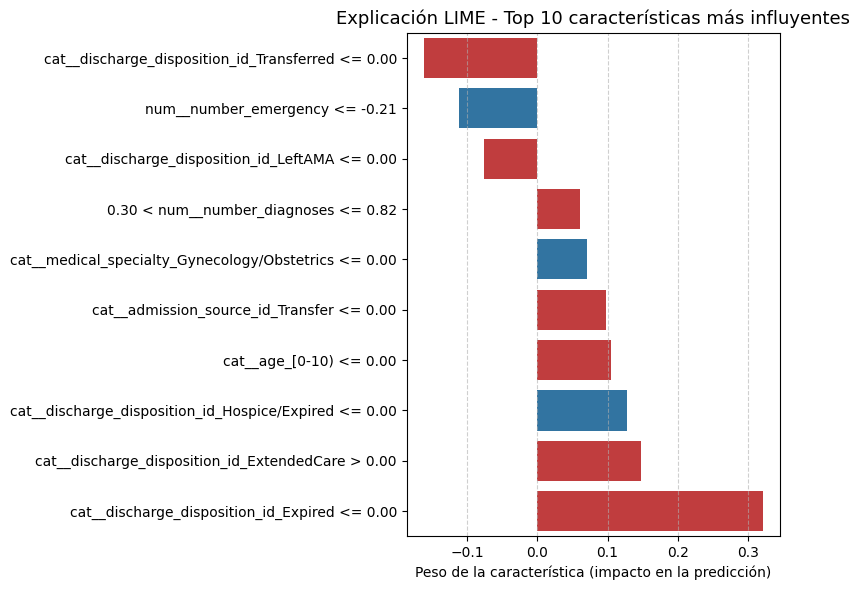

In [75]:
plt.figure(figsize=(8, 6))
colors = ["#d62728" if w > 0 else "#1f77b4" for w in df_lime["Peso"]]

sns.barplot(
    data=df_lime.sort_values(by="Peso", ascending=True),
    x="Peso",
    y="Característica",
    palette=colors
)

plt.title("Explicación LIME - Top 10 características más influyentes", fontsize=13)
plt.xlabel("Peso de la característica (impacto en la predicción)")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [76]:
svm_model = svm_best.named_steps["classifier"]
feature_names = svm_best.named_steps["preprocessor"].get_feature_names_out()
coefs = svm_model.coef_.flatten()

importances = np.abs(coefs)

feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coeficiente": coefs,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False).reset_index(drop=True)

In [77]:
top10 = feat_importance.head(25)
print(" Top 25 características más importantes en SVM:")
display(top10)


 Top 25 características más importantes en SVM:


Feature  Coeficiente  \
0               cat__discharge_disposition_id_Expired    -1.689891   
1       cat__discharge_disposition_id_Hospice/Expired    -0.868074   
2                  cat__discharge_disposition_id_Home     0.773411   
3           cat__discharge_disposition_id_Transferred     0.740206   
4          cat__discharge_disposition_id_ExtendedCare     0.661543   
5                               num__number_inpatient     0.481611   
6               cat__discharge_disposition_id_LeftAMA     0.399593   
7                   cat__admission_source_id_Transfer    -0.390177   
8        cat__medical_specialty_Gynecology/Obstetrics    -0.382339   
9              cat__admission_source_id_EmergencyRoom     0.261592   
10  cat__medical_specialty_InternalMedicine-Subspe...     0.207442   
11                              num__number_emergency     0.190646   
12                                   cat__age_[70-80)     0.179092   
13                                cat__race_Caucasian     0.178432   
14                  cat__admission_source_id_Referral     0.176553   
15                              num__number_diagnoses     0.158283   
16                          cat__race_AfricanAmerican     0.148005   
17                                   cat__age_[80-90)     0.143422   
18                                  cat__age_[90-100)    -0.142824   
19                       cat__medical_specialty_Other     0.135065   
20                                    cat__race_Asian    -0.132882   
21                                    cat__age_[0-10)    -0.125140   
22                            cat__max_glu_serum_>300     0.120712   
23                 cat__medical_specialty_Diagnostics     0.117903   
24                                cat__A1Cresult_none     0.113399   

    Importancia  
0      1.689891  
1      0.868074  
2      0.773411  
3      0.740206  
4      0.661543  
5      0.481611  
6      0.399593  
7      0.390177  
8      0.382339  
9      0.261592  
10     0.207442  
11     0.190646  
12     0.179092  
13     0.178432  
14     0.176553  
15     0.158283  
16     0.148005  
17     0.143422  
18     0.142824  
19     0.135065  
20     0.132882  
21     0.125140  
22     0.120712  
23     0.117903  
24     0.113399

C:\Users\taran\AppData\Local\Temp\ipykernel_16700\811798012.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Importancia", y="Feature", palette="Reds_r")


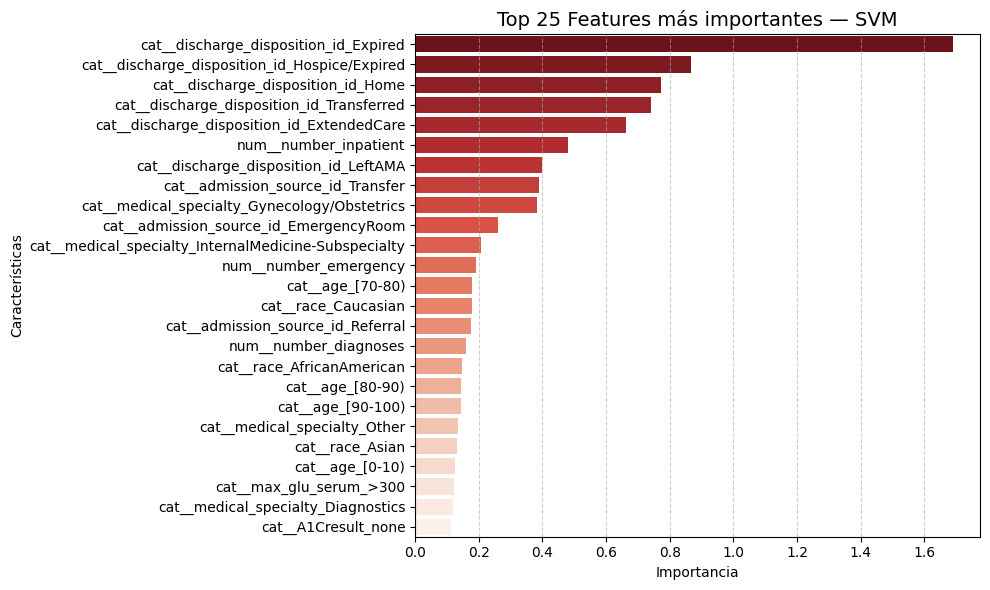

In [78]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10, x="Importancia", y="Feature", palette="Reds_r")
plt.title("Top 25 Features más importantes — SVM", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## **7.9.3 Ridge (SAGA) + SMOTE + GridSearch , CV=5**

In [79]:
logres_best = joblib.load("best_ridge_saga_model.pkl")

In [80]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

X_train_trans = logres_best.named_steps["preprocessor"].transform(X_train)
X_test_trans = logres_best.named_steps["preprocessor"].transform(X_test)

explainer = LimeTabularExplainer(
    training_data=np.array(X_train_trans),
    feature_names=logres_best.named_steps["preprocessor"].get_feature_names_out(),
    class_names=["No", "Sí"],      # Ajusta según tu variable dependiente
    mode="classification"
)


In [81]:
i = 10  # índice de la muestra que quieras analizar
exp = explainer.explain_instance(
    data_row=X_test_trans[i],
    predict_fn=logres_best.named_steps["classifier"].predict_proba,
    num_features=10  # cuántas características mostrar
)

exp.show_in_notebook(show_table=True)

In [82]:
pred_proba = logres_best.named_steps["classifier"].predict_proba([X_test_trans[i]])[0]
pred_class = np.argmax(pred_proba)

lime_features = exp.as_list()
df_lime = pd.DataFrame(lime_features, columns=["Característica", "Peso"])

df_lime["abs_peso"] = df_lime["Peso"].abs()
df_lime = df_lime.sort_values(by="abs_peso", ascending=False).reset_index(drop=True)

print("=" * 70)
print(f"Interpretación LIME para la muestra #{i}")
print("-" * 70)
print(f"Clase predicha: {'Sí' if pred_class == 1 else 'No'}")
print(f"Probabilidades -> No: {pred_proba[0]:.3f} | Sí: {pred_proba[1]:.3f}")
print("\nTop 10 características más influyentes:")
print(df_lime[["Característica", "Peso"]].to_string(index=False))
print("=" * 70)


Interpretación LIME para la muestra #10
----------------------------------------------------------------------
Clase predicha: Sí
Probabilidades -> No: 0.355 | Sí: 0.645

Top 10 características más influyentes:
                                       Característica      Peso
        cat__discharge_disposition_id_Expired <= 0.00  0.497822
    cat__discharge_disposition_id_ExtendedCare > 0.00  0.280730
    cat__discharge_disposition_id_Transferred <= 0.00 -0.262542
        cat__discharge_disposition_id_LeftAMA <= 0.00 -0.259562
cat__discharge_disposition_id_Hospice/Expired <= 0.00  0.235414
         cat__admission_type_id_Trauma Center <= 0.00  0.180600
 cat__medical_specialty_Gynecology/Obstetrics <= 0.00  0.133698
                              cat__age_[0-10) <= 0.00  0.120794
                            cat__miglitol_Yes <= 0.00 -0.090967
   cat__discharge_disposition_id_StillPatient <= 0.00 -0.028768


C:\Users\taran\AppData\Local\Temp\ipykernel_16700\1163203388.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


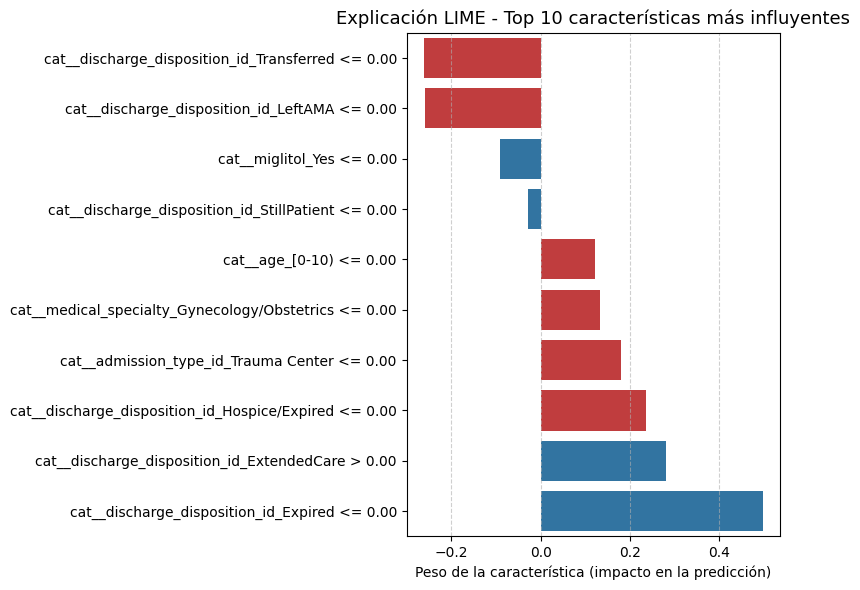

In [83]:
plt.figure(figsize=(8, 6))
colors = ["#d62728" if w > 0 else "#1f77b4" for w in df_lime["Peso"]]

sns.barplot(
    data=df_lime.sort_values(by="Peso", ascending=True),
    x="Peso",
    y="Característica",
    palette=colors
)

plt.title("Explicación LIME - Top 10 características más influyentes", fontsize=13)
plt.xlabel("Peso de la característica (impacto en la predicción)")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [84]:
logres_model = logres_best.named_steps["classifier"]
feature_names = logres_best.named_steps["preprocessor"].get_feature_names_out()
coefs = logres_model.coef_.flatten()

importances = np.abs(coefs)

feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coeficiente": coefs,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False).reset_index(drop=True)

In [85]:
top10 = feat_importance.head(25)
print(" Top 25 características más importantes en LogRes:")
display(top10)


 Top 25 características más importantes en LogRes:


Feature  Coeficiente  Importancia
0           cat__discharge_disposition_id_Expired    -5.224460     5.224460
1       cat__discharge_disposition_id_Transferred     1.532095     1.532095
2              cat__discharge_disposition_id_Home     1.493626     1.493626
3           cat__discharge_disposition_id_LeftAMA     1.430766     1.430766
4      cat__discharge_disposition_id_ExtendedCare     1.388074     1.388074
5            cat__admission_type_id_Trauma Center    -1.217122     1.217122
6   cat__discharge_disposition_id_Hospice/Expired    -1.154245     1.154245
7    cat__medical_specialty_Gynecology/Obstetrics    -0.658475     0.658475
8                                 cat__age_[0-10)    -0.619004     0.619004
9                           num__number_inpatient     0.495880     0.495880
10               cat__admission_source_id_Newborn    -0.420242     0.420242
11                               cat__miglitol_No    -0.411955     0.411955
12     cat__discharge_disposition_id_StillPatient     0.398942     0.398942
13                  cat__admission_type_id_Urgent     0.376830     0.376830
14                            cat__tolazamide_Yes    -0.358969     0.358969
15              cat__admission_source_id_Transfer    -0.355587     0.355587
16               cat__admission_type_id_Emergency     0.340981     0.340981
17         cat__admission_source_id_EmergencyRoom     0.339277     0.339277
18                    cat__gender_Unknown/Invalid    -0.333811     0.333811
19                    cat__glipizide-metformin_No    -0.321095     0.321095
20                              cat__miglitol_Yes     0.276752     0.276752
21              cat__admission_source_id_Referral     0.262327     0.262327
22                          cat__acetohexamide_No    -0.239536     0.239536
23                                cat__race_Asian    -0.236268     0.236268
24                               cat__acarbose_No    -0.233710     0.233710

C:\Users\taran\AppData\Local\Temp\ipykernel_16700\811798012.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Importancia", y="Feature", palette="Reds_r")


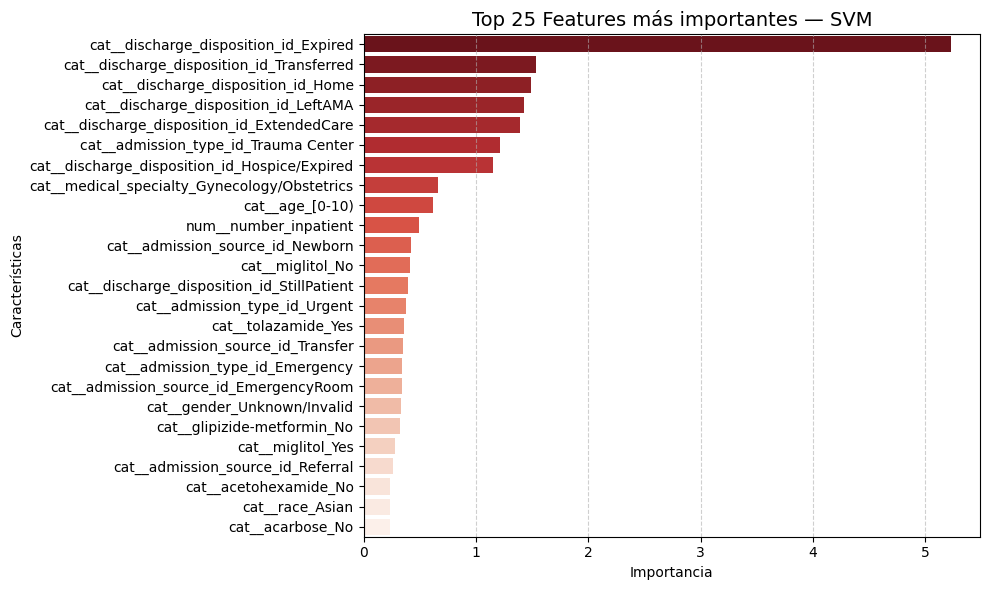

In [86]:
plt.figure(figsize=(10,6))
sns.barplot(data=top10, x="Importancia", y="Feature", palette="Reds_r")
plt.title("Top 25 Features más importantes — SVM", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()